In [10]:
import sys
sys.path.append('/home/jjwhit/rcGAN/')

In [11]:
import torch
import yaml
import types
import json

import numpy as np
import matplotlib.patches as patches

from data.lightning.MassMappingDataModule import MMDataModule
from utils.parse_args import create_arg_parser
from pytorch_lightning import seed_everything
from models.lightning.mmGAN import mmGAN
from utils.mri.math import tensor_to_complex_np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import ndimage

In [101]:
%run /home/jjwhit/rcGAN/scripts/mass_map/plot.py --config /home/jjwhit/rcGAN/configs/mass_map.yml --exp-name mmgan_training_cosmos --num-figs 1

[rank: 0] Global seed set to 1


In [7]:
import numpy  as np

In [8]:
def ks93(g1, g2):
    """Direct inversion of weak-lensing shear to convergence.

    This function is an implementation of the Kaiser & Squires (1993) mass
    mapping algorithm. Due to the mass sheet degeneracy, the convergence is
    recovered only up to an overall additive constant. It is chosen here to
    produce output maps of mean zero. The inversion is performed in Fourier
    space for speed.

    Parameters
    ----------
    g1, g2 : array_like
        2D input arrays corresponding to the first and second (i.e., real and
        imaginary) components of shear, binned spatially to a regular grid.

    Returns
    -------
    kE, kB : tuple of numpy arrays
        E-mode and B-mode maps of convergence.

    Raises
    ------
    AssertionError
        For input arrays of different sizes.

    See Also
    --------
    bin2d
        For binning a galaxy shear catalog.

    Examples
    --------
    >>> # (g1, g2) should in practice be measurements from a real galaxy survey
    >>> g1, g2 = 0.1 * np.random.randn(2, 32, 32) + 0.1 * np.ones((2, 32, 32))
    >>> kE, kB = ks93(g1, g2)
    >>> kE.shape
    (32, 32)
    >>> kE.mean()
    1.0842021724855044e-18

    """
    # Check consistency of input maps
    assert g1.shape == g2.shape

    # Compute Fourier space grids
    (nx, ny) = g1.shape
    k1, k2 = np.meshgrid(np.fft.fftfreq(ny), np.fft.fftfreq(nx))

    # Compute Fourier transforms of g1 and g2
    g1hat = np.fft.fft2(g1)
    g2hat = np.fft.fft2(g2)

    # Apply Fourier space inversion operator
    p1 = k1 * k1 - k2 * k2
    p2 = 2 * k1 * k2
    k2 = k1 * k1 + k2 * k2
    k2[0, 0] = 1  # avoid division by 0
    kEhat = (p1 * g1hat + p2 * g2hat) / k2
    kBhat = -(p2 * g1hat - p1 * g2hat) / k2

    # Transform back to pixel space
    kE = np.fft.ifft2(kEhat).real
    kB = np.fft.ifft2(kBhat).real

    return kE, kB


def ks93inv(kE, kB):
    """Direct inversion of weak-lensing convergence to shear.

    This function provides the inverse of the Kaiser & Squires (1993) mass
    mapping algorithm, namely the shear is recovered from input E-mode and
    B-mode convergence maps.

    Parameters
    ----------
    kE, kB : array_like
        2D input arrays corresponding to the E-mode and B-mode (i.e., real and
        imaginary) components of convergence.

    Returns
    -------
    g1, g2 : tuple of numpy arrays
        Maps of the two components of shear.

    Raises
    ------
    AssertionError
        For input arrays of different sizes.

    See Also
    --------
    ks93
        For the forward operation (shear to convergence).

    """
    # Check consistency of input maps
    assert kE.shape == kB.shape

    # Compute Fourier space grids
    (nx, ny) = kE.shape
    k1, k2 = np.meshgrid(np.fft.fftfreq(ny), np.fft.fftfreq(nx))

    # Compute Fourier transforms of kE and kB
    kEhat = np.fft.fft2(kE)
    kBhat = np.fft.fft2(kB)

    # Apply Fourier space inversion operator
    p1 = k1 * k1 - k2 * k2
    p2 = 2 * k1 * k2
    k2 = k1 * k1 + k2 * k2
    k2[0, 0] = 1  # avoid division by 0
    g1hat = (p1 * kEhat - p2 * kBhat) / k2
    g2hat = (p2 * kEhat + p1 * kBhat) / k2

    # Transform back to pixel space
    g1 = np.fft.ifft2(g1hat).real
    g2 = np.fft.ifft2(g2hat).real

    return g1, g2

In [10]:
std1 = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_std1.npy', allow_pickle=True)
std2 = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_std2.npy', allow_pickle=True)

In [11]:
import torch
import yaml
import types
import json

import numpy as np
import matplotlib.patches as patches

import sys
sys.path.append('/home/jjwhit/rcGAN/')

from data.lightning.MassMappingDataModule import MMDataModule
from data.lightning.MassMappingDataModule import MMDataTransform #import compute_fourier_kernel, realistic_noise_maker
from utils.parse_args import create_arg_parser
from pytorch_lightning import seed_everything
from models.lightning.mmGAN import mmGAN
from utils.mri.math import tensor_to_complex_np
from mass_map_utils.scripts.ks_utils import backward_model, Gaussian_smoothing
from scipy import ndimage
import sys

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import find_contours

In [12]:
D = MMDataTransform.compute_fourier_kernel(300)

In [14]:
D.shape

(300, 300)

In [15]:
gamma_sim = MMDataTransform.forward_model(np_gt,D)  + std1*np.random.randn(300,300) + 1.j * std2 * np.random.randn(300,300)

In [25]:
kappa_sim = ks93(gamma_sim.real, gamma_sim.imag)

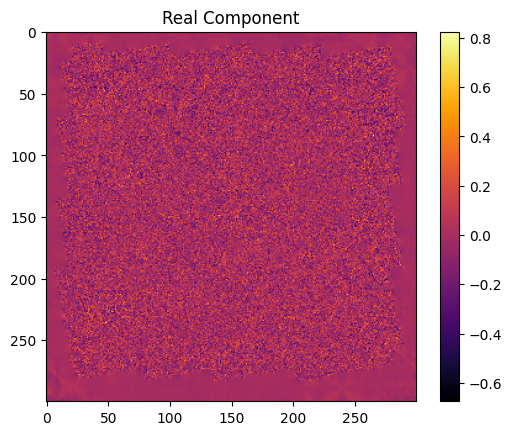

In [33]:
real_component = kappa_sim[0]

# Plot the real component using plt.imshow
plt.imshow(real_component, cmap='inferno')  # You can use any colormap you prefer
plt.title('Real Component')
plt.colorbar()
plt.show()

In [3]:
mask =  np.load(
                    '/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_mask.npy', allow_pickle=True
                ).astype(bool)

In [85]:
kappa = np.load('/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_test/cropped_sim_01000.npy', allow_pickle=True)

In [86]:
kappa.dtype

dtype('float64')

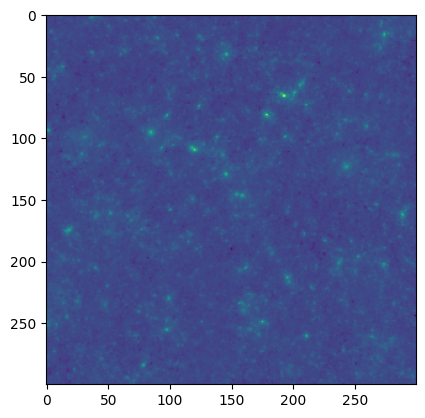

In [8]:
plt.imshow(kappa.real)

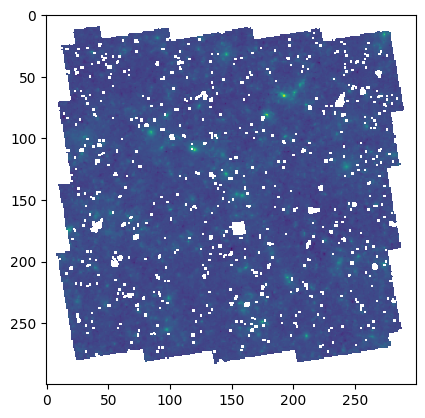

In [9]:
plt.imshow(np.ma.masked_where(mask == False, kappa.real))

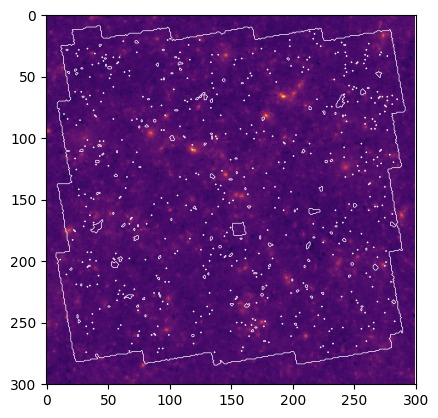

In [5]:
plt.imshow(kappa.real, cmap='inferno')

# Plot the boundaries of the mask using contour
contour = plt.contour(mask, colors='white', linewidths=.5, levels=[0.5], extent=(0, kappa.real.shape[1], 0, kappa.real.shape[0]))


# Show the plot
plt.show()

In [6]:
from skimage.measure import find_contours

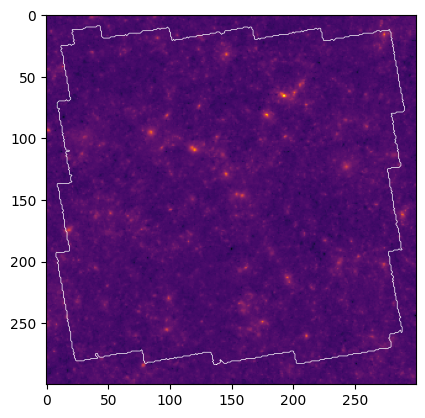

In [7]:
contours = find_contours(mask, 0.5)
# Select the outer contour based on the area
outer_contour = max(contours, key=lambda x: x.shape[0])

# Plot the array using imshow
plt.imshow(kappa.real, cmap='inferno')

# Plot only the outer contour
plt.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)

# Show the plot
plt.show()

In [21]:
zoom_length = 80  # Adjust this value based on your preference
margin = 10  # Adjust this value to set the margin

# Ensure the square is not touching the edge
zoom_startx = np.random.randint(margin, 300 - zoom_length - margin)
zoom_starty1 = np.random.randint(margin, int(300 / 2) - zoom_length - margin)
zoom_starty2 = np.random.randint(int(300 / 2) + margin, 300 - zoom_length - margin)

p = np.random.rand()
zoom_starty = zoom_starty1 if p <= 0.5 else zoom_starty2

x_coord = zoom_startx + zoom_length
y_coords = [zoom_starty, zoom_starty + zoom_length]


In [37]:
def compute_fourier_kernel(N: int) -> np.ndarray:
  """Computes the Fourier space kernel which represents the mapping between 
    convergence (kappa) and shear (gamma).
  Args:
    N (int): x,y dimension of image patch (assumes square images).
  Returns:
    𝒟 (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].
  """
  # Generate grid of Fourier domain
  kx = np.arange(N).astype(np.float64) - N/2
  ky, kx = np.meshgrid(kx, kx)
  k = kx**2+ky**2
  # Define Kaiser-Squires kernel
  𝒟 = np.zeros((N, N), dtype=np.complex128)
  𝒟 = np.where(k > 0, ((kx ** 2.0 - ky ** 2.0) + 1j * (2.0 * kx * ky))/k, 𝒟)
  # Apply inverse FFT shift 
  return np.fft.ifftshift(𝒟)

In [38]:
def forward_model(𝜅: np.ndarray, 𝒟: np.ndarray) -> np.ndarray:
  """Applies the forward mapping between convergence and shear through their 
    relationship in Fourier space.
  Args:
    𝜅 (np.ndarray): Convergence field, with shape [N,N].
    𝒟 (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].
  Returns:
    γ (np.ndarray): Shearing field, with shape [N,N].
  """
  𝓕𝜅 = np.fft.fft2(𝜅) # Perform 2D forward FFT
  𝓕γ = 𝓕𝜅 * 𝒟 # Map convergence onto shear
  return np.fft.ifft2(𝓕γ) # Perform 2D inverse FFT

In [39]:
def backward_model(γ: np.ndarray, 𝒟: np.ndarray) -> np.ndarray:
  """Applies the backward mapping between shear and convergence through their 
    relationship in Fourier space.
  Args:
    γ (np.ndarray): Shearing field, with shape [N,N].
    𝒟 (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].
  Returns:
    𝜅 (np.ndarray): Convergence field, with shape [N,N].
  """
  𝓕γ = np.fft.fft2(γ) # Perform 2D forward FFT
  𝓕𝜅 = 𝓕γ / 𝒟 # Map convergence onto shear
  𝓕𝜅 = np.nan_to_num(𝓕𝜅, nan=0, posinf=0, neginf=0) # Remove singularities
  return np.fft.ifft2(𝓕𝜅) # Perform 2D inverse FFT

In [44]:
def noise_maker(kappa: np.ndarray, std1, std2) -> np.ndarray:
    """Adds realistic simulated Gaussian noise to a mock weak lensing map.

    Args:
        im_size (int): Size of weak lensing map, in pixels.
        kappa (np.ndarray): Convergence map.
    
    Returns:
        gamma (np.ndarray): A synthetic representation of the shear field, gamma, with added noise.
    """

    D = compute_fourier_kernel(300) #Fourier kernel
    gamma = forward_model(kappa, D) + (
        std1 * np.random.randn(300,300) + 1.j * std2 * np.random.randn(300,300)
    )
    return gamma

In [41]:
def Gaussian_smoothing(kappa,m,n,theta,ngrid):
    """Applies Gaussian smoothing to a convergence map.

    This is done by taking Fourier transform of the convergence map, and a Gaussian,
    convolving them, and then applying an inverse Fourier transform to the result.

    Args:
        kappa (np.ndarray): Convergence map.
        m,n (int, int): The dimensions, in pixels, of kappa.
        theta (float): Opening angle in deg.
        ngrid (int): Number of grids.

    Returns:
        smoothed_kappa (np.ndarray): Returns a smoothed representation of the the convergence field.
    """
    kappa_f = np.fft.fft2(kappa) #Fourier transform of kappa
    kappa_f_shifted = np.fft.fftshift(kappa_f) #Changes the indexing of the Fourier coefficients
    
    Gaussian_filter = np.zeros((m,n))
    i = (25*ngrid)/(60*theta)
    sig_pix = i/(2*ngrid*np.sqrt(2*np.log(2)))

    s = int(m/2)
    t = int(n/2)
    x = np.arange(-s,s)
    y = np.arange(-t,t)
    xx,yy = np.meshgrid(x,y)

    const = 1/(np.sqrt(2*np.pi*sig_pix**2))
    exponential = np.exp(-(xx**2 + yy**2)*2*(sig_pix*np.pi)**2)
    Gaussian_filter = const*exponential

    smoothed_kappa_f = np.fft.ifftshift(kappa_f_shifted*Gaussian_filter)
    smoothed_kappa = np.fft.ifft2(smoothed_kappa_f)
    return smoothed_kappa

In [47]:
stand1 = np.load(
                    '/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_std1.npy', allow_pickle=True
                )
stand2 = np.load(
                    '/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_std2.npy', allow_pickle=True
                )

In [54]:
gamma_sim = noise_maker(kappa, stand1, stand2)

/tmp/ipykernel_65415/3120372928.py:15: RuntimeWarning: invalid value encountered in divide
  𝒟 = np.where(k > 0, ((kx ** 2.0 - ky ** 2.0) + 1j * (2.0 * kx * ky))/k, 𝒟)


In [53]:
D = compute_fourier_kernel(300)
kappa_sim = backward_model(gamma_sim,D)

/tmp/ipykernel_65415/3120372928.py:15: RuntimeWarning: invalid value encountered in divide
  𝒟 = np.where(k > 0, ((kx ** 2.0 - ky ** 2.0) + 1j * (2.0 * kx * ky))/k, 𝒟)
/tmp/ipykernel_65415/2932275313.py:11: RuntimeWarning: divide by zero encountered in divide
  𝓕𝜅 = 𝓕γ / 𝒟 # Map convergence onto shear


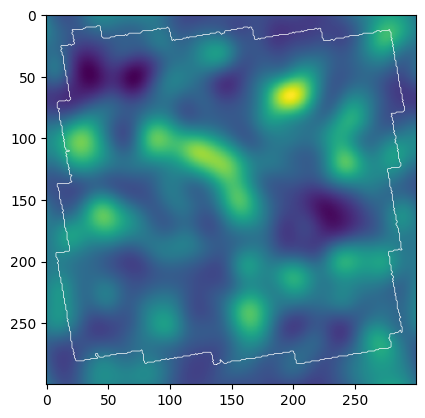

In [55]:
kappa_synth = Gaussian_smoothing(kappa_sim,300,300,5.0,300)
plt.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
plt.imshow(kappa_synth.real)

In [89]:
e1map = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_full_e1_0.29arcmin360.npy').astype('float64')
e2map = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_full_e2_0.29arcmin360.npy').astype('float64')

In [90]:
e1map.shape

(360, 360)

In [91]:
cosmos_shear = e1map + 1j*e2map

In [92]:
shear_magnitude = np.abs(cosmos_shear)

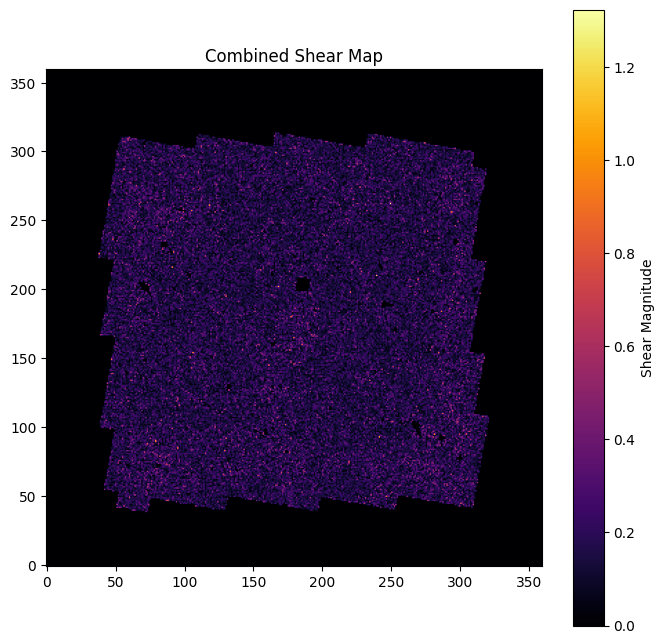

In [93]:
plt.figure(figsize=(8, 8))
plt.imshow(shear_magnitude, cmap='inferno', origin='lower')
plt.colorbar(label='Shear Magnitude')
plt.title('Combined Shear Map')
plt.show()

In [39]:
np.save('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_shear_magnitude.npy', shear_magnitude)

In [88]:
shear_magnitude.dtype

dtype('float32')

In [49]:
target_size=  (300,300)

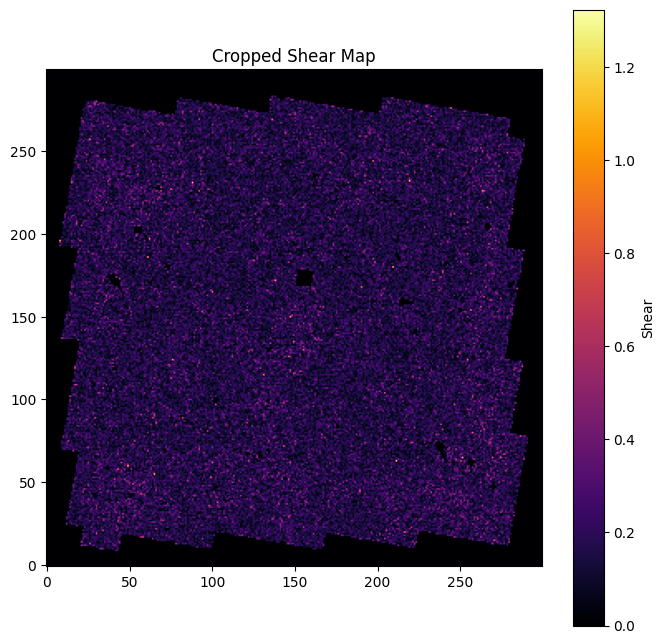

In [95]:
center_x, center_y = shear_magnitude.shape[0] // 2, shear_magnitude.shape[1] // 2

# Set the desired crop size
crop_size = 300

# Calculate the crop boundaries
crop_x_start = center_x - crop_size // 2
crop_x_end = center_x + crop_size // 2
crop_y_start = center_y - crop_size // 2
crop_y_end = center_y + crop_size // 2

# Crop the shear magnitude
cropped_shear= shear_magnitude[crop_x_start:crop_x_end, crop_y_start:crop_y_end]

# Visualize the cropped shear map
plt.figure(figsize=(8, 8))
plt.imshow(cropped_shear.real, cmap='inferno', origin='lower')
plt.colorbar(label='Shear')
plt.title('Cropped Shear Map')
plt.show()

In [97]:
cropped_shear.dtype

dtype('float64')

In [99]:
np.save('/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/cosmos/cosmos_shear_mag_cropped.npy',cropped_shear)

Test plot on Cosmos data

In [64]:
mmGAN_model = mmGAN.load_from_checkpoint('/share/gpu0/jjwhit/mass_map/mm_models/mmgan_training_cosmos/checkpoint_best.ckpt')

In [67]:
mmGAN_model.cuda()
mmGAN_model.eval()

mmGAN(
  (generator): UNetModel(
    (down_sample_layers): ModuleList(
      (0): ConvDownBlock(
        (conv_1): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (res): ResidualBlock(
          (conv_block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): PReLU(num_parameters=1)
            (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): PReLU(num_parameters=1)
          )
          (conv_1x1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): PReLU(

In [61]:
input = cropped_shear

In [63]:
if __name__ == "__main__":
    torch.set_float32_matmul_precision('medium')
    args = create_arg_parser().parse_args()  # You need to define create_arg_parser() function
    seed_everything(1, workers=True)

    config_path = args.config

    with open(config_path, 'r') as f:
        cfg = yaml.load(f, Loader=yaml.FullLoader)
        cfg = json.loads(json.dumps(cfg), object_hook=load_object)

    dm = MMDataModule(cfg)
    fig_count = 1
    dm.setup()

    # Load a single test image
    single_image_path = 'path/to/your/single/image.jpg'  # Change this to the path of your test image
    single_image = load_single_image(single_image_path)  # You need to implement the function load_single_image()

    single_image = torch.unsqueeze(single_image, 0)  # Add batch dimension

    with torch.no_grad():
        mmGAN_model = YourGAN.load_from_checkpoint(
            checkpoint_path=cfg.checkpoint_dir + args.exp_name + '/checkpoint_best.ckpt')

        mmGAN_model.cuda()
        mmGAN_model.eval()

        y = single_image.cuda()
        mean = torch.mean(y)
        std = torch.std(y)

        gens_mmGAN = torch.zeros(size=(y.size(0), cfg.num_z_test, cfg.im_size, cfg.im_size, 2)).cuda()

        for z in range(cfg.num_z_test):
            gens_mmGAN[:, z, :, :, :] = mmGAN_model.reformat(mmGAN_model.forward(y))

        avg_mmGAN = torch.mean(gens_mmGAN, dim=1)

        np_avgs = {
            'mmGAN': None,
        }

        np_samps = {
            'mmGAN': [],
        }

        np_stds = {
            'mmGAN': None,
        }

        np_gt = None

        np_gt = ndimage.rotate(
            torch.tensor(tensor_to_complex_np((y * std + mean).cpu())).abs().numpy(), 180)

        np_avgs['mmGAN'] = ndimage.rotate(
            torch.tensor(tensor_to_complex_np((avg_mmGAN[0] * std + mean).cpu())).abs().numpy(),
            180)

        for z in range(cfg.num_z_test):
            np_samps['mmGAN'].append(ndimage.rotate(torch.tensor(
                tensor_to_complex_np((gens_mmGAN[0, z] * std + mean).cpu())).abs().numpy(), 180))

        np_stds['mmGAN'] = np.std(np.stack(np_samps['mmGAN']), axis=0)

        method = 'mmGAN'

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)